#                      Credit Card Fraud Detector

## Introduction
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

Due to confidentiality issues, there are not provided the original features and more background information about the data.

Features V1, V2, ... V28 are the principal components obtained with PCA;
The only features which have not been transformed with PCA are Time and Amount. Feature Time contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature Amount is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Installing the necessary Packages And Libraries

## Importing Libraries

In [5]:
%pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

## Loading the Dataset

In [4]:
df=pd.read_csv("creditcard.csv")

Converting the datatype of 'Amount' Coulmn

In [6]:
print(df.dtypes)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


In [8]:
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

## Checking the Data

In [10]:
print("Credit Card Fraud Detection data -  rows:",df.shape[0]," columns:", df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


## Glimpse the data

We start by looking to the data features (first 5 rows).

In [12]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Let's look into more details to the data.

In [14]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Looking to the **Time** feature, we can confirm that the data contains **284,807** transactions, during 2 consecutive days (or **172792** seconds).

In [16]:
# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

## Check missing data

Let's check if there is any missing data.

In [18]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

## Data unbalance

Let's check data unbalance with respect with target value, i.e. Class.

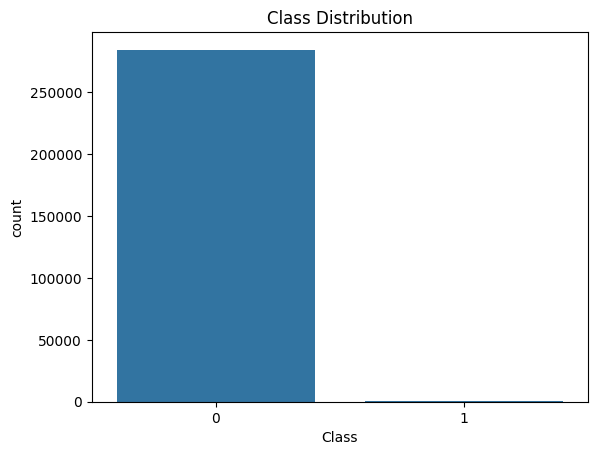

In [20]:
# Visualize the distribution of the target variable
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

Only **492** (or **0.172%**) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable **Class.**

## Split Data into Training and Test Sets

In [22]:
# Train-test split with imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Check the shape
X_train.shape

(227845, 30)

In [26]:
X_test.shape

(56962, 30)

## Train and Evaluate Model on Imbalanced Data

Train a model and evaluate its performance on the imbalanced dataset.

In [65]:
def train_model(X_train, X_test, y_train, y_test):
    """
    Trains and evaluates multiple classifiers on the given training and test datasets.

    This function takes training and test feature sets and labels, trains three different classifiers
    (Logistic Regression, Decision Tree Classifier, and RandomForestClassifier) on the training data, 
    and evaluates their performance on the test data. For each classifier, it prints the confusion matrix, 
    classification report, ROC-AUC score, and plots the ROC curve.

    Parameters:
    X_train (pd.DataFrame or np.ndarray): Features of the training data.
    X_test (pd.DataFrame or np.ndarray): Features of the test data.
    y_train (pd.Series or np.ndarray): Labels of the training data.
    y_test (pd.Series or np.ndarray): Labels of the test data.

    Returns:
    None: This function does not return any values but prints evaluation metrics and plots.

    Notes:
    - The function assumes that the test data includes both positive and negative class samples.
    - ROC-AUC scores and ROC curves are only meaningful if the classifier provides probability estimates 
      for the positive class.
    - This function will display the ROC curves in separate plots for each classifier.
    """
    
    classifier = {
        "Logistic Regression": LogisticRegression(),
        "Decision Tree Classifier": DecisionTreeClassifier(),
        "RandomForestClassifier": RandomForestClassifier(random_state=42)
    }

    for name, model in classifier.items():
        print(f"\n================ {name} ================\n")
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix:\n{conf_matrix}\n")

        # Accuracy
        print(f"\nAccuracy: {accuracy_score(y_test, y_pred)}\n")
        
        # Classification report
        clf_report = classification_report(y_test, y_pred)
        print(f"\nClassification Report:\n{clf_report}\n")
    
        # ROC-AUC Score
        roc_auc = roc_auc_score(y_test, y_pred)
        print(f"ROC-AUC Score (Imbalanced Data): {roc_auc}\n")
    
        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (Imbalanced Data)\nusing {name}', fontsize=10)
        plt.legend(loc='best')
        plt.show()
        print("\n")


================ Logistic Regression ================



C:\Users\shubh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Confusion Matrix:
[[56829    35]
 [   43    55]]


Accuracy: 0.9986306660580738


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.61      0.56      0.59        98

    accuracy                           1.00     56962
   macro avg       0.81      0.78      0.79     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.7803044930690339



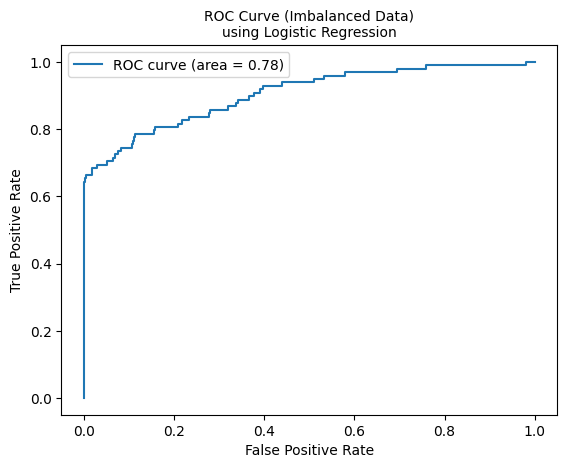




================ Decision Tree Classifier ================

Confusion Matrix:
[[56834    30]
 [   18    80]]


Accuracy: 0.9991573329588147


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.82      0.77        98

    accuracy                           1.00     56962
   macro avg       0.86      0.91      0.88     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.9078994780241867



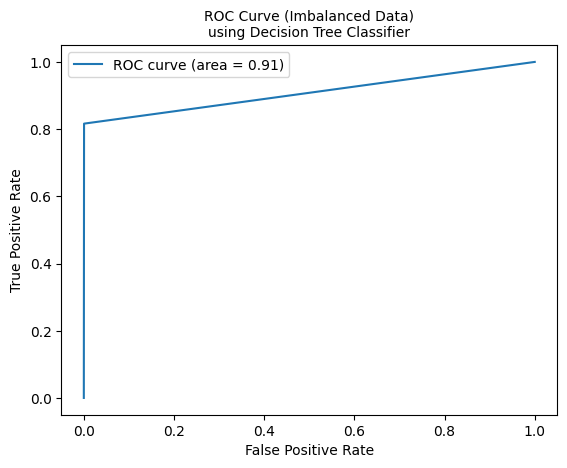




================ RandomForestClassifier ================

Confusion Matrix:
[[56862     2]
 [   23    75]]


Accuracy: 0.9995611109160493


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.8826354754056941



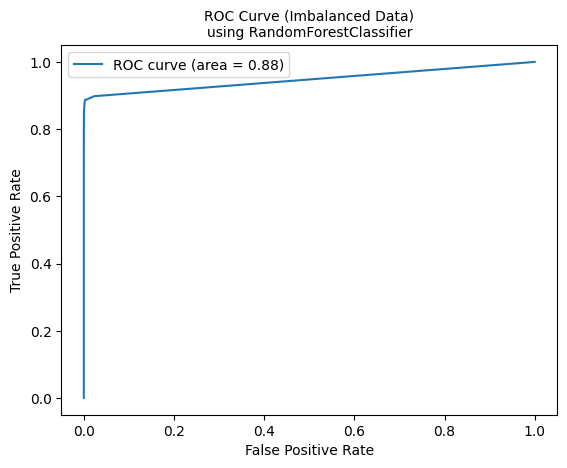

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Call the train_model function
train_model(X_train, X_test, y_train, y_test)

## Handling Imbalanced Data

### Two techniques:
- Undersampling
- Oversampling

## Undersampling

In [68]:
# Separate normal and fraud transactions
normal = df[df['Class']==0]
fraud = df[df['Class']==1]

# Print shape for reference
print(f"Normal transactions shape: {normal.shape}")
print(f"Fraud transactions shape: {fraud.shape}")

Normal transactions shape: (284315, 31)
Fraud transactions shape: (492, 31)


In [17]:
# Undersample normal transactions
normal_sample = normal.sample(n=fraud.shape[0])

In [19]:
# Print the shape of the new normal transactions
print(f"New normal transactions shape: {normal_sample.shape}")

New normal transactions shape: (492, 31)


In [21]:
# Concate updated normal transcations with old fraud transaction and make a new df
new_df = pd.concat([normal_sample, fraud], ignore_index=True)

In [23]:
# Print few rows of new df
new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,120143.0,-0.327030,-0.212214,0.094281,-1.074203,0.296025,-1.285096,0.423248,-0.324333,-1.229355,0.573590,-1.395526,-1.014028,-0.494104,0.349894,0.388653,-1.607124,-0.172546,1.440955,-0.546716,-0.600601,-0.037718,0.450963,0.224206,-0.100173,-0.725275,0.739605,0.066563,0.194735,9.00,0
1,33147.0,1.051586,-0.127370,0.457837,1.231389,-0.371678,0.035395,-0.085750,0.062614,0.327452,-0.037064,0.566659,1.119386,-0.047196,0.038964,-1.095326,-0.151444,-0.355648,0.220428,0.409720,-0.000690,0.010563,0.112340,-0.235982,0.025559,0.738231,-0.291087,0.023546,0.019677,71.99,0
2,35374.0,-1.040416,0.801019,0.520615,-1.093590,0.252097,-0.879767,0.794456,0.115595,-0.526791,-0.252235,0.813699,0.462137,-0.259529,0.511914,-0.464168,0.510985,-0.772241,0.103109,-0.046934,0.020606,0.034872,0.100157,-0.107423,0.068540,-0.310862,0.769982,-0.151524,-0.119364,38.90,0
3,39350.0,1.135113,-0.166531,0.201388,-0.015134,-0.573703,-1.113814,0.205343,-0.302180,0.110913,-0.258139,-0.149633,0.538682,0.679796,0.172196,0.998876,0.212695,-0.314465,-0.699051,0.155815,0.145716,-0.174949,-0.673539,0.020112,0.404137,0.166033,0.838906,-0.100233,0.020230,90.69,0
4,66053.0,1.189747,-0.021842,1.066522,1.213686,-0.688981,0.116035,-0.547268,0.105690,0.875823,-0.211469,-1.211402,0.489349,0.474425,-0.460769,0.179668,0.218418,-0.463159,0.070319,-0.011486,-0.093105,-0.093377,-0.044208,-0.075326,-0.132914,0.498185,-0.377154,0.073918,0.033744,9.99,0


In [25]:
# Check new class distribution
new_df['Class'].value_counts()

Class
0    492
1    492
Name: count, dtype: int64

In [27]:
# Split new df into X and y
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [29]:
# Train test split on Undersampled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


================ Logistic Regression ================



C:\Users\shubh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Confusion Matrix:
[[56829    35]
 [   43    55]]


Accuracy: 0.9986306660580738


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.61      0.56      0.59        98

    accuracy                           1.00     56962
   macro avg       0.81      0.78      0.79     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.7803044930690339



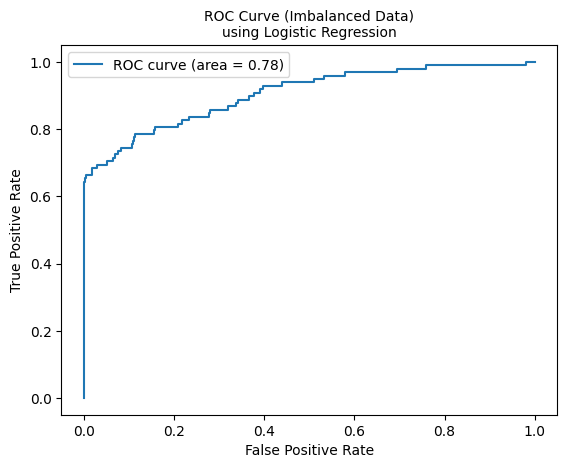




================ Decision Tree Classifier ================

Confusion Matrix:
[[56838    26]
 [   17    81]]


Accuracy: 0.9992451107756047


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.83      0.79        98

    accuracy                           1.00     56962
   macro avg       0.88      0.91      0.89     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.9130366904781045



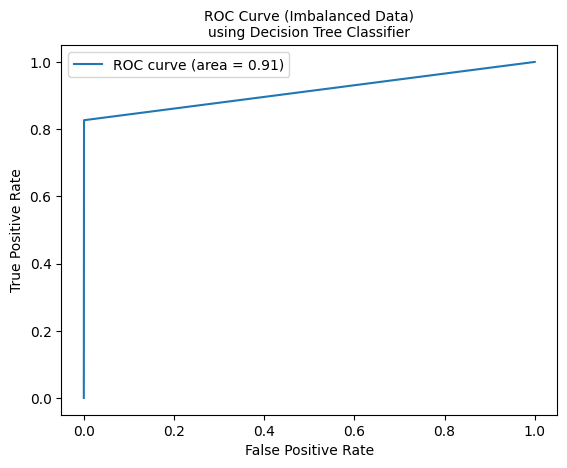




================ RandomForestClassifier ================

Confusion Matrix:
[[56862     2]
 [   23    75]]


Accuracy: 0.9995611109160493


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score (Imbalanced Data): 0.8826354754056941



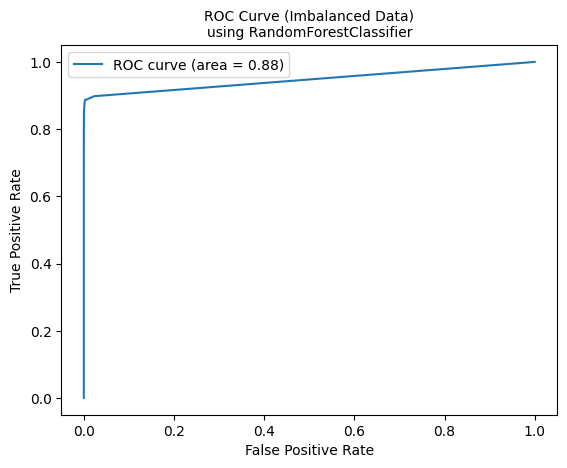

In [69]:
# Train models with undersampled data
# Call the train_model function
train_model(X_train, X_test, y_train, y_test)

# Oversampling

- Use SMOTE to balance the dataset by oversampling the minority class

In [75]:
from imblearn.over_sampling import SMOTE

In [77]:
# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

In [79]:
# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [81]:
# Check new class distribution
y_resampled.value_counts()

Class
0    284315
1    284315
Name: count, dtype: int64

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


================ Logistic Regression ================



C:\Users\shubh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Confusion Matrix:
[[55734  1016]
 [ 1954 55022]]


Accuracy: 0.973884599827656


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     56750
           1       0.98      0.97      0.97     56976

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726


ROC-AUC Score (Imbalanced Data): 0.9739008872427312



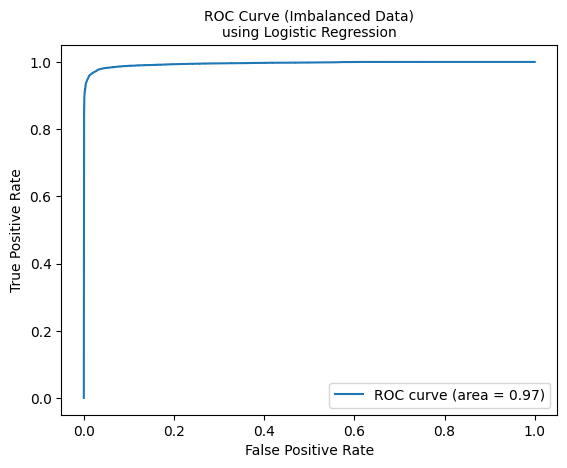




================ Decision Tree Classifier ================

Confusion Matrix:
[[56622   128]
 [   27 56949]]


Accuracy: 0.9986370750751807


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726


ROC-AUC Score (Imbalanced Data): 0.998635304825774



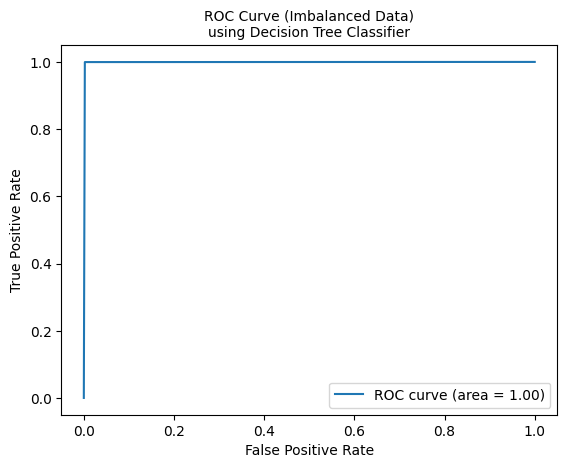




================ RandomForestClassifier ================



In [ ]:
# Train models with undersampled data
# Call the train_model function
train_model(X_train, X_test, y_train, y_test)

## Handling Imbalanced Data:

We applied techniques such as undersampling and oversampling to address the class imbalance. This was crucial in ensuring that our models could better learn from the minority class.

# Data exploration

## Transactions in time

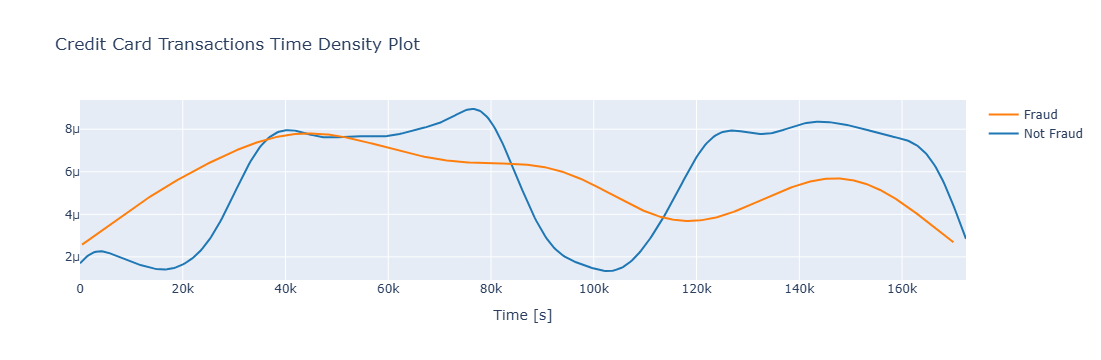

In [7]:
Not_Fraud = df.loc[df['Class'] == 0]["Time"]
Fraud = df.loc[df['Class'] == 1]["Time"]

hist_data = [Not_Fraud, Fraud]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

Let's look into more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour. We assume (based on observation of the time distribution of transactions) that the time unit is second.

In [9]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


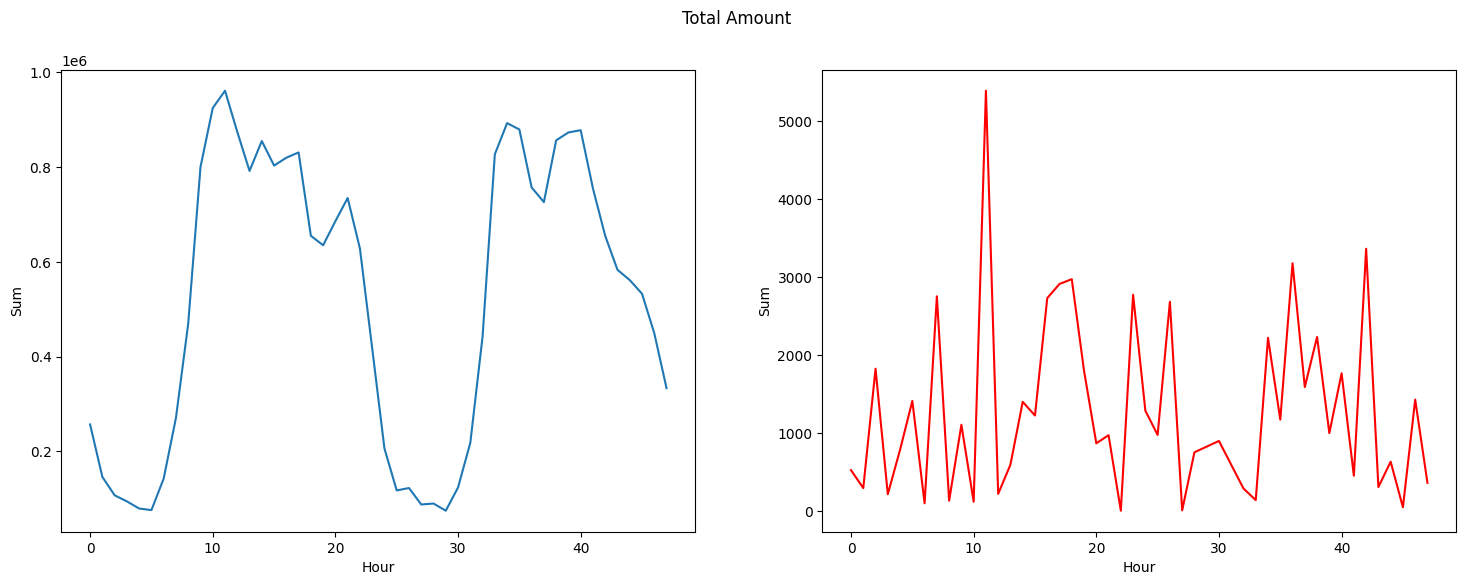

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show()

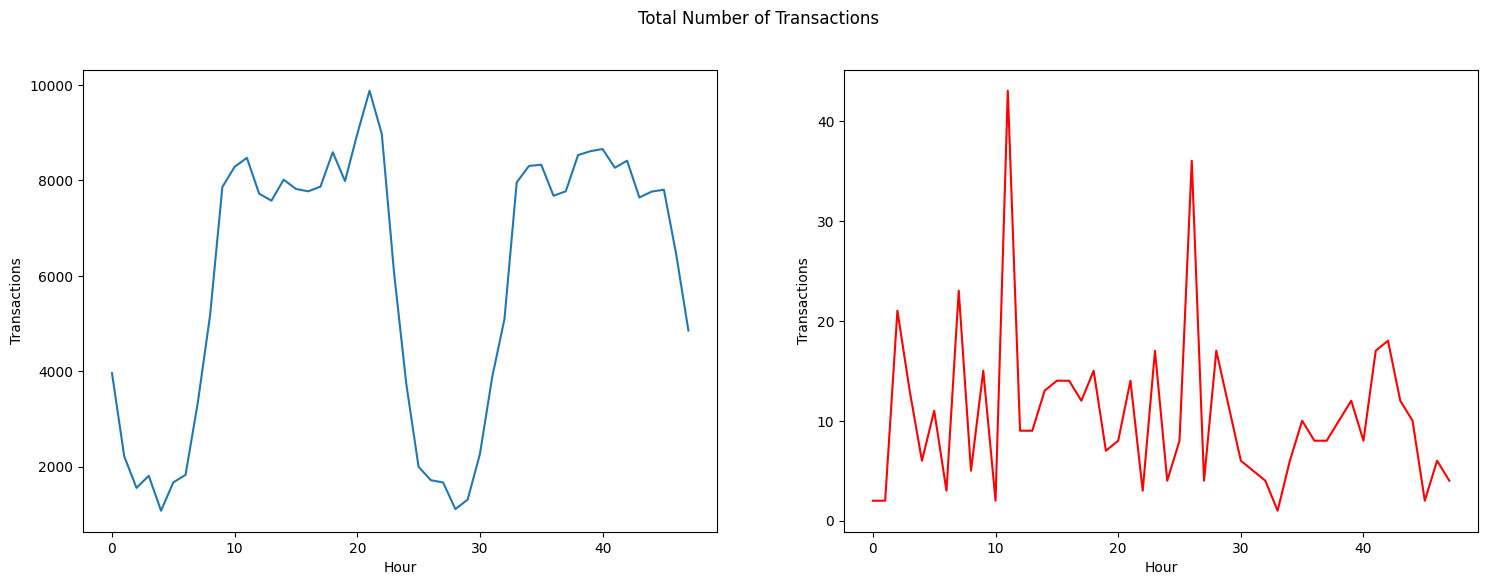

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show()

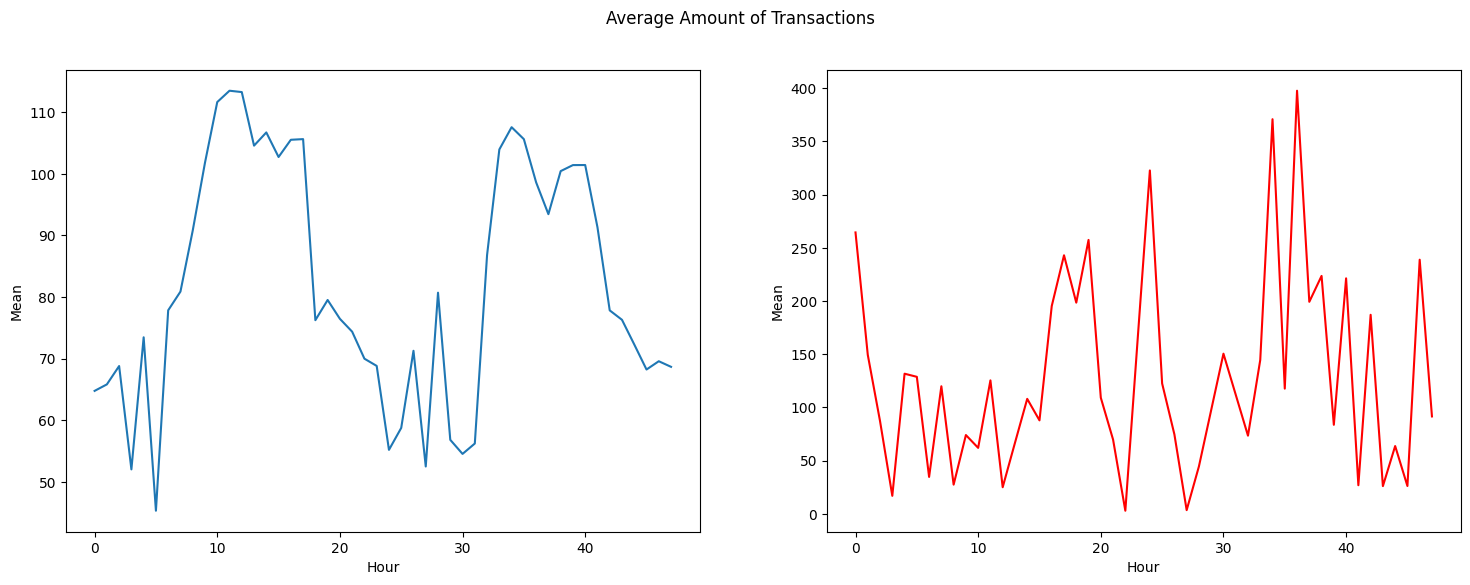

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show()

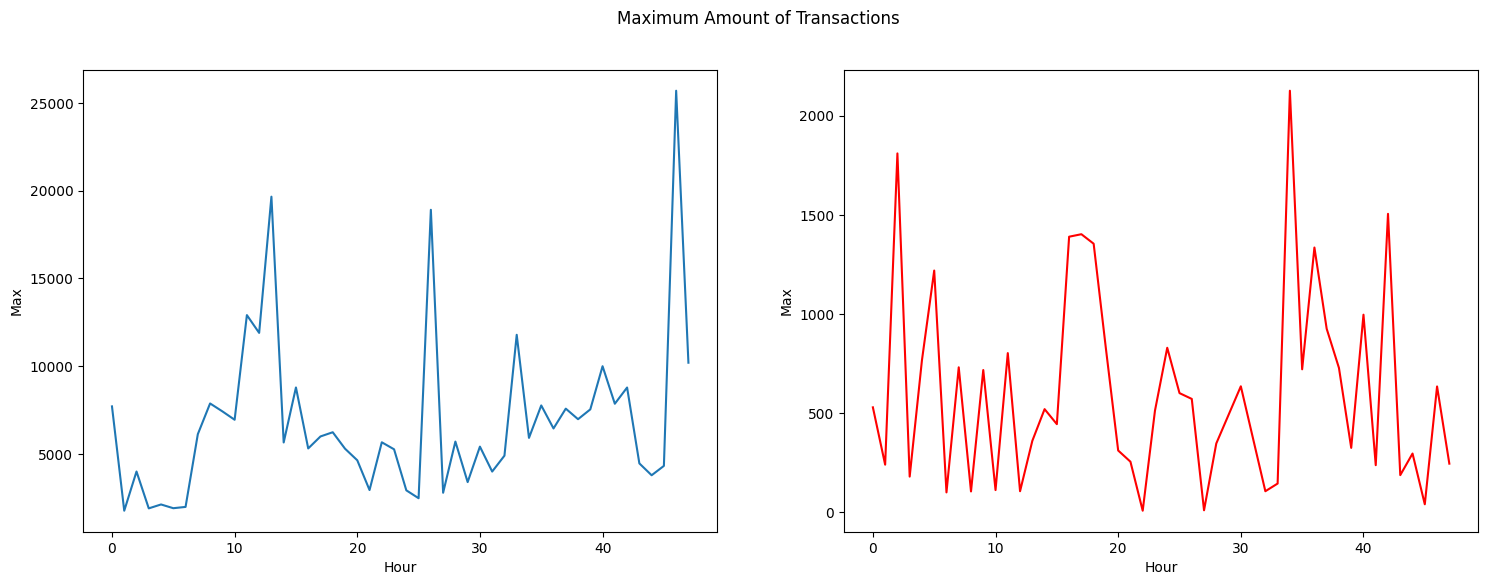

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show()

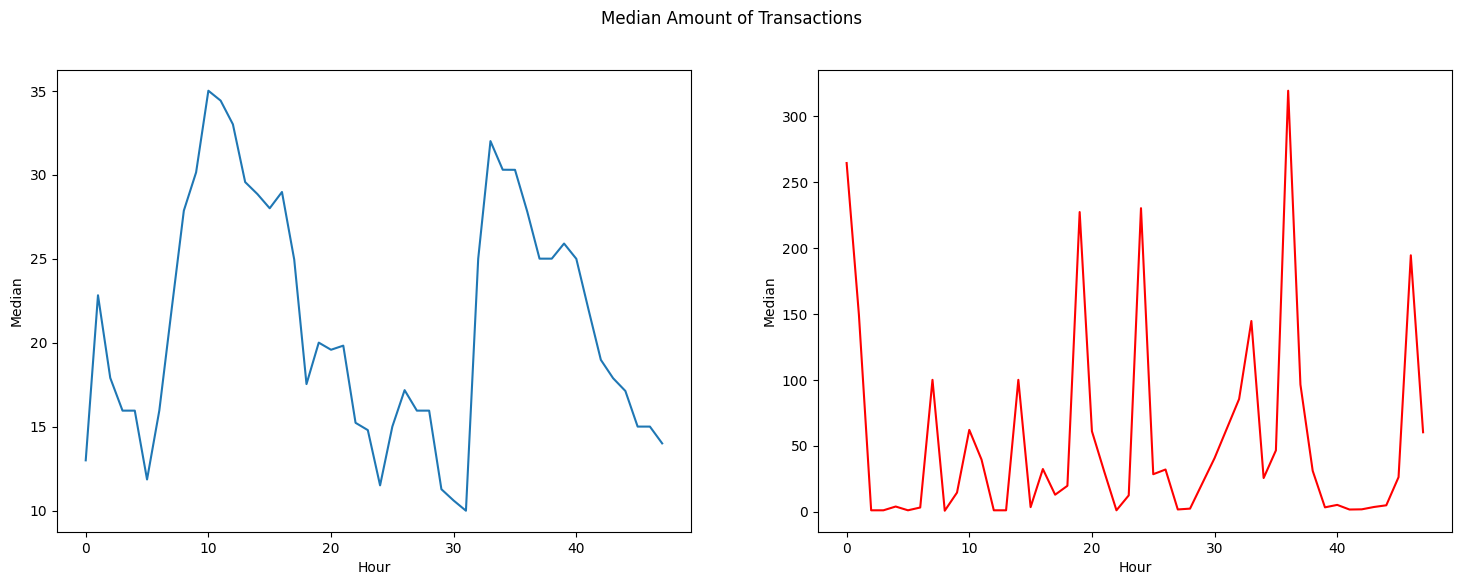

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show()

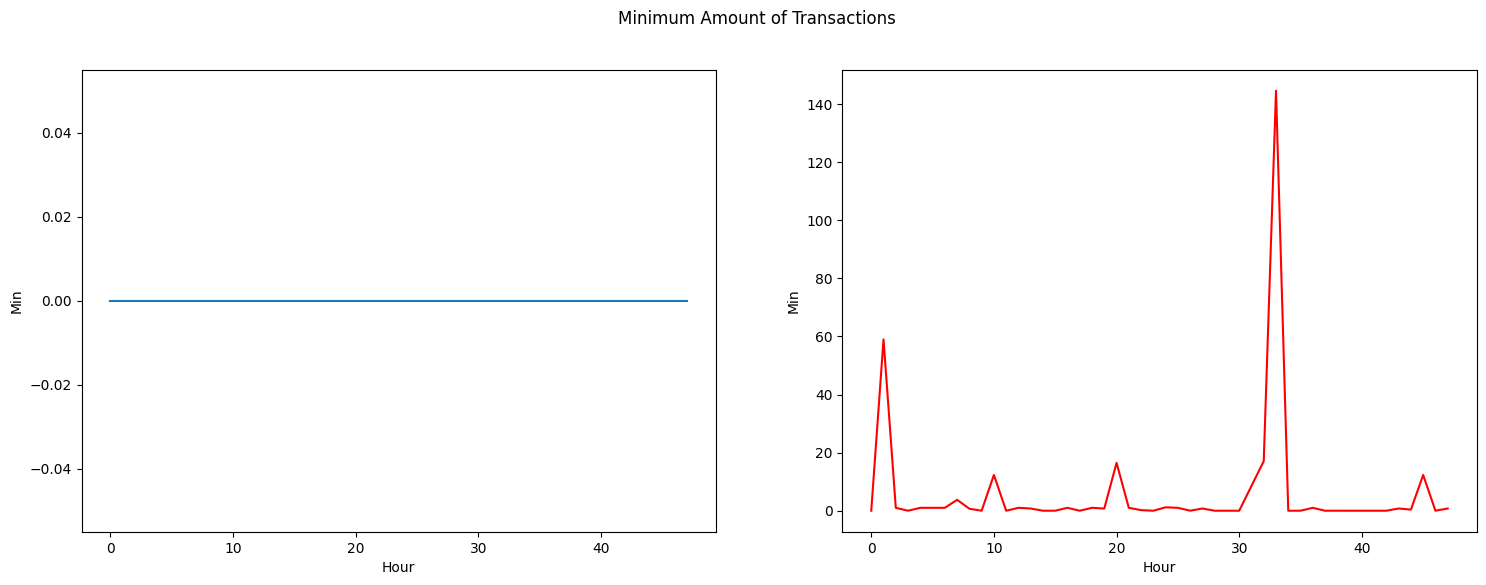

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show()

## Transactions amount

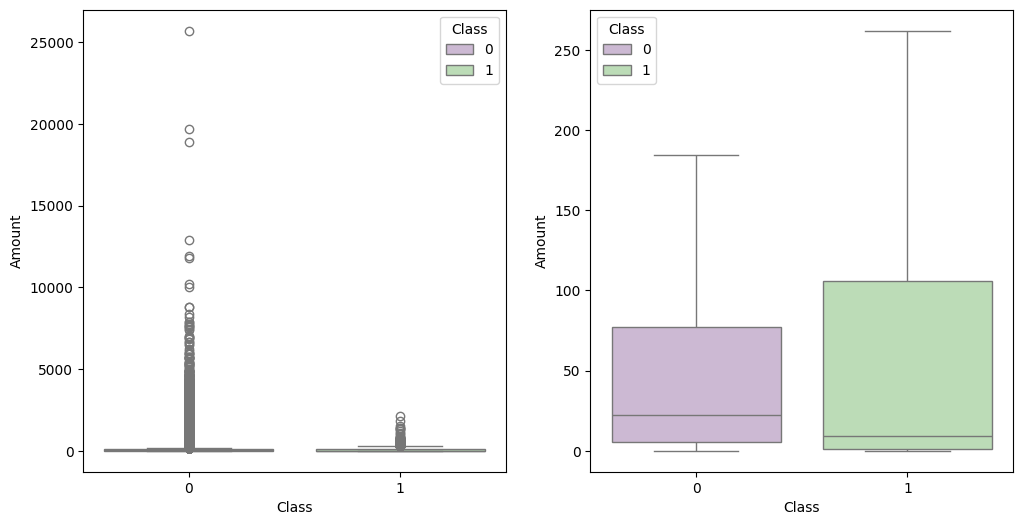

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)
plt.show()

In [57]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

In [59]:
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [61]:
tmp = df[['Amount','Class']].copy()
Not_fraud = tmp.loc[tmp['Class'] == 0]['Amount']
Fraud = tmp.loc[tmp['Class'] == 1]['Amount']

In [63]:
Not_fraud.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [65]:
Fraud.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

Let's plot the fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

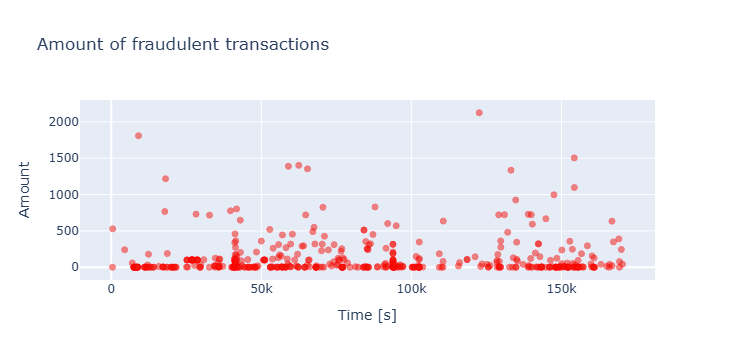

In [68]:
fraud = df.loc[df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

## Features correlation

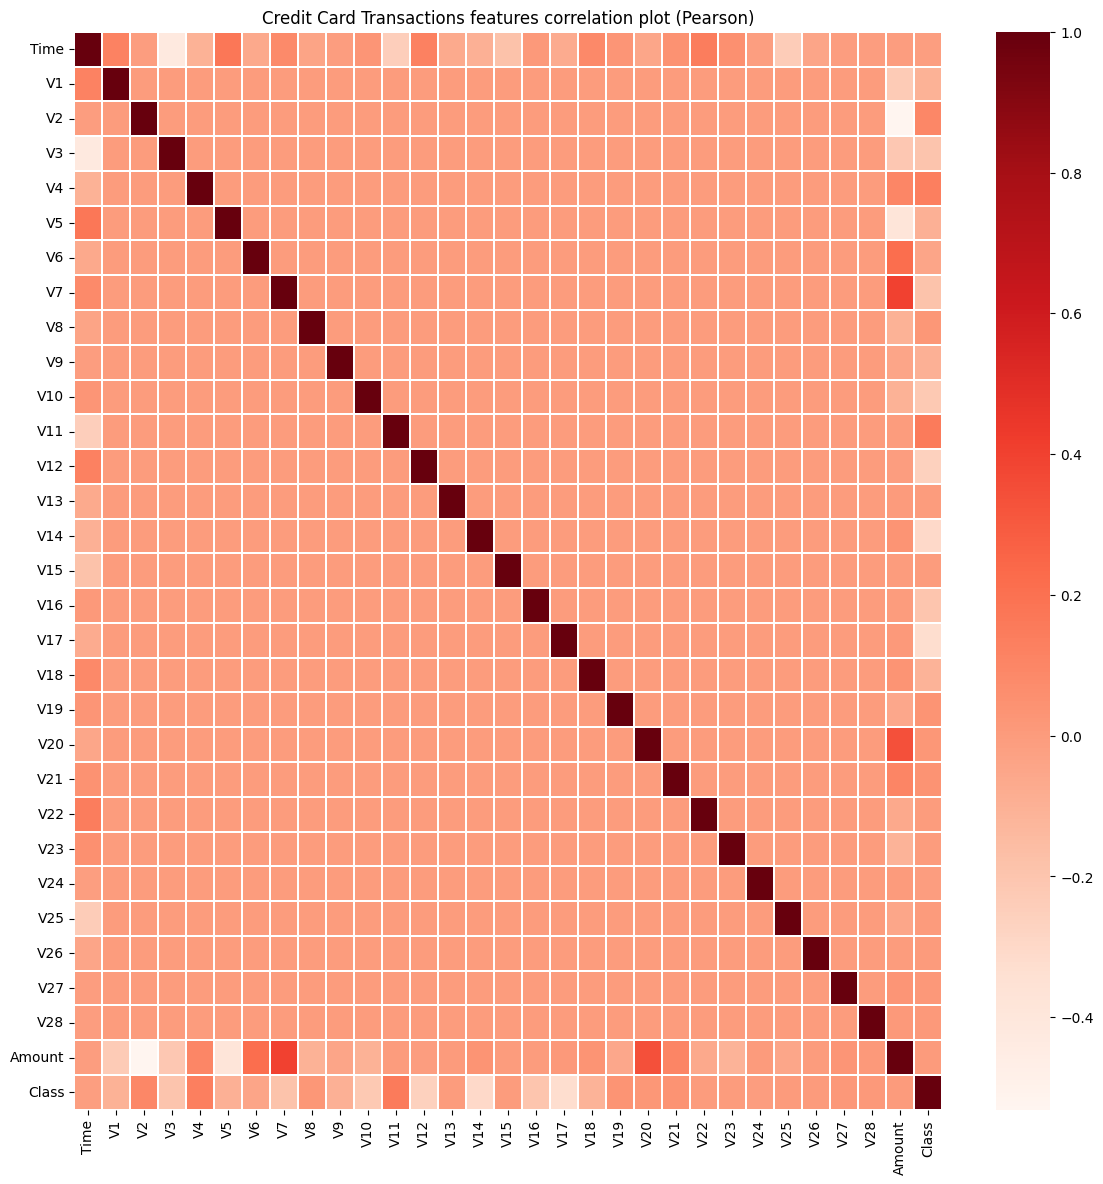

In [71]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

As expected, there is no notable correlation between features **V1-V28**. There are certain correlations between some of these features and **Time** (inverse correlation with **V3**) and **Amount** (direct correlation with **V7** and **V20**, inverse correlation with **V1 and V5**).

Let's plot the correlated and inverse correlated values on the same graph.

Let's start with the direct correlated values: {V20;Amount} and {V7;Amount}.

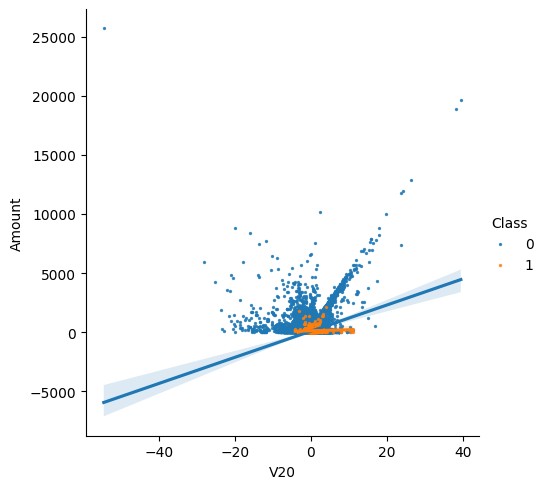

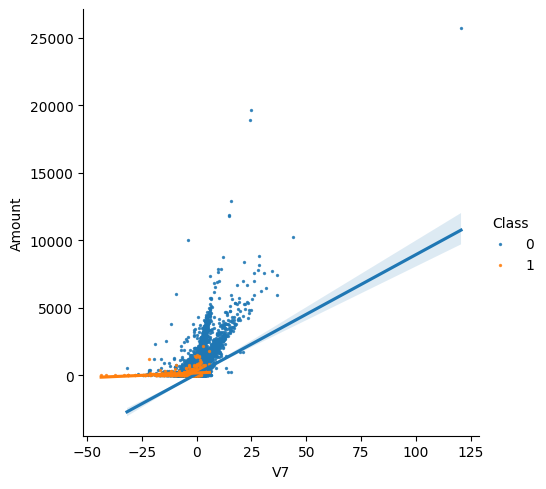

In [11]:
s = sns.lmplot(x='V20', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()


We can confirm that the two couples of features are correlated (the regression lines for **Class = 0** have a positive slope, whilst the regression line for **Class = 1** have a smaller positive slope).

Let's plot now the inverse correlated values.

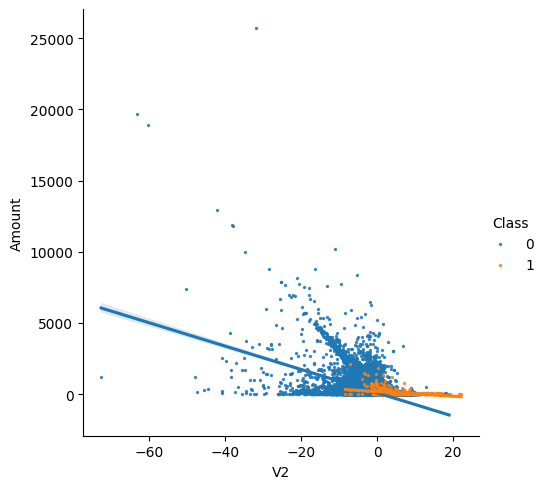

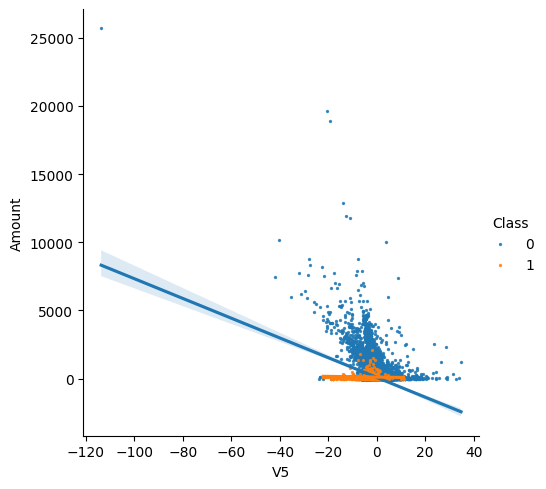

In [12]:
s = sns.lmplot(x='V2', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for **Class = 0** have a negative slope while the regression lines for **Class = 1** have a very small negative slope).

## Features density plot

C:\Users\shubh\AppData\Local\Temp\ipykernel_28736\2137072470.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\shubh\AppData\Local\Temp\ipykernel_28736\2137072470.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\shubh\AppData\Local\Temp\ipykernel_28736\2137072470.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\shubh\AppData\Local\Temp\ipykernel_28736\2137072470.py:15: UserWarning:



The `bw` paramet

<Figure size 640x480 with 0 Axes>

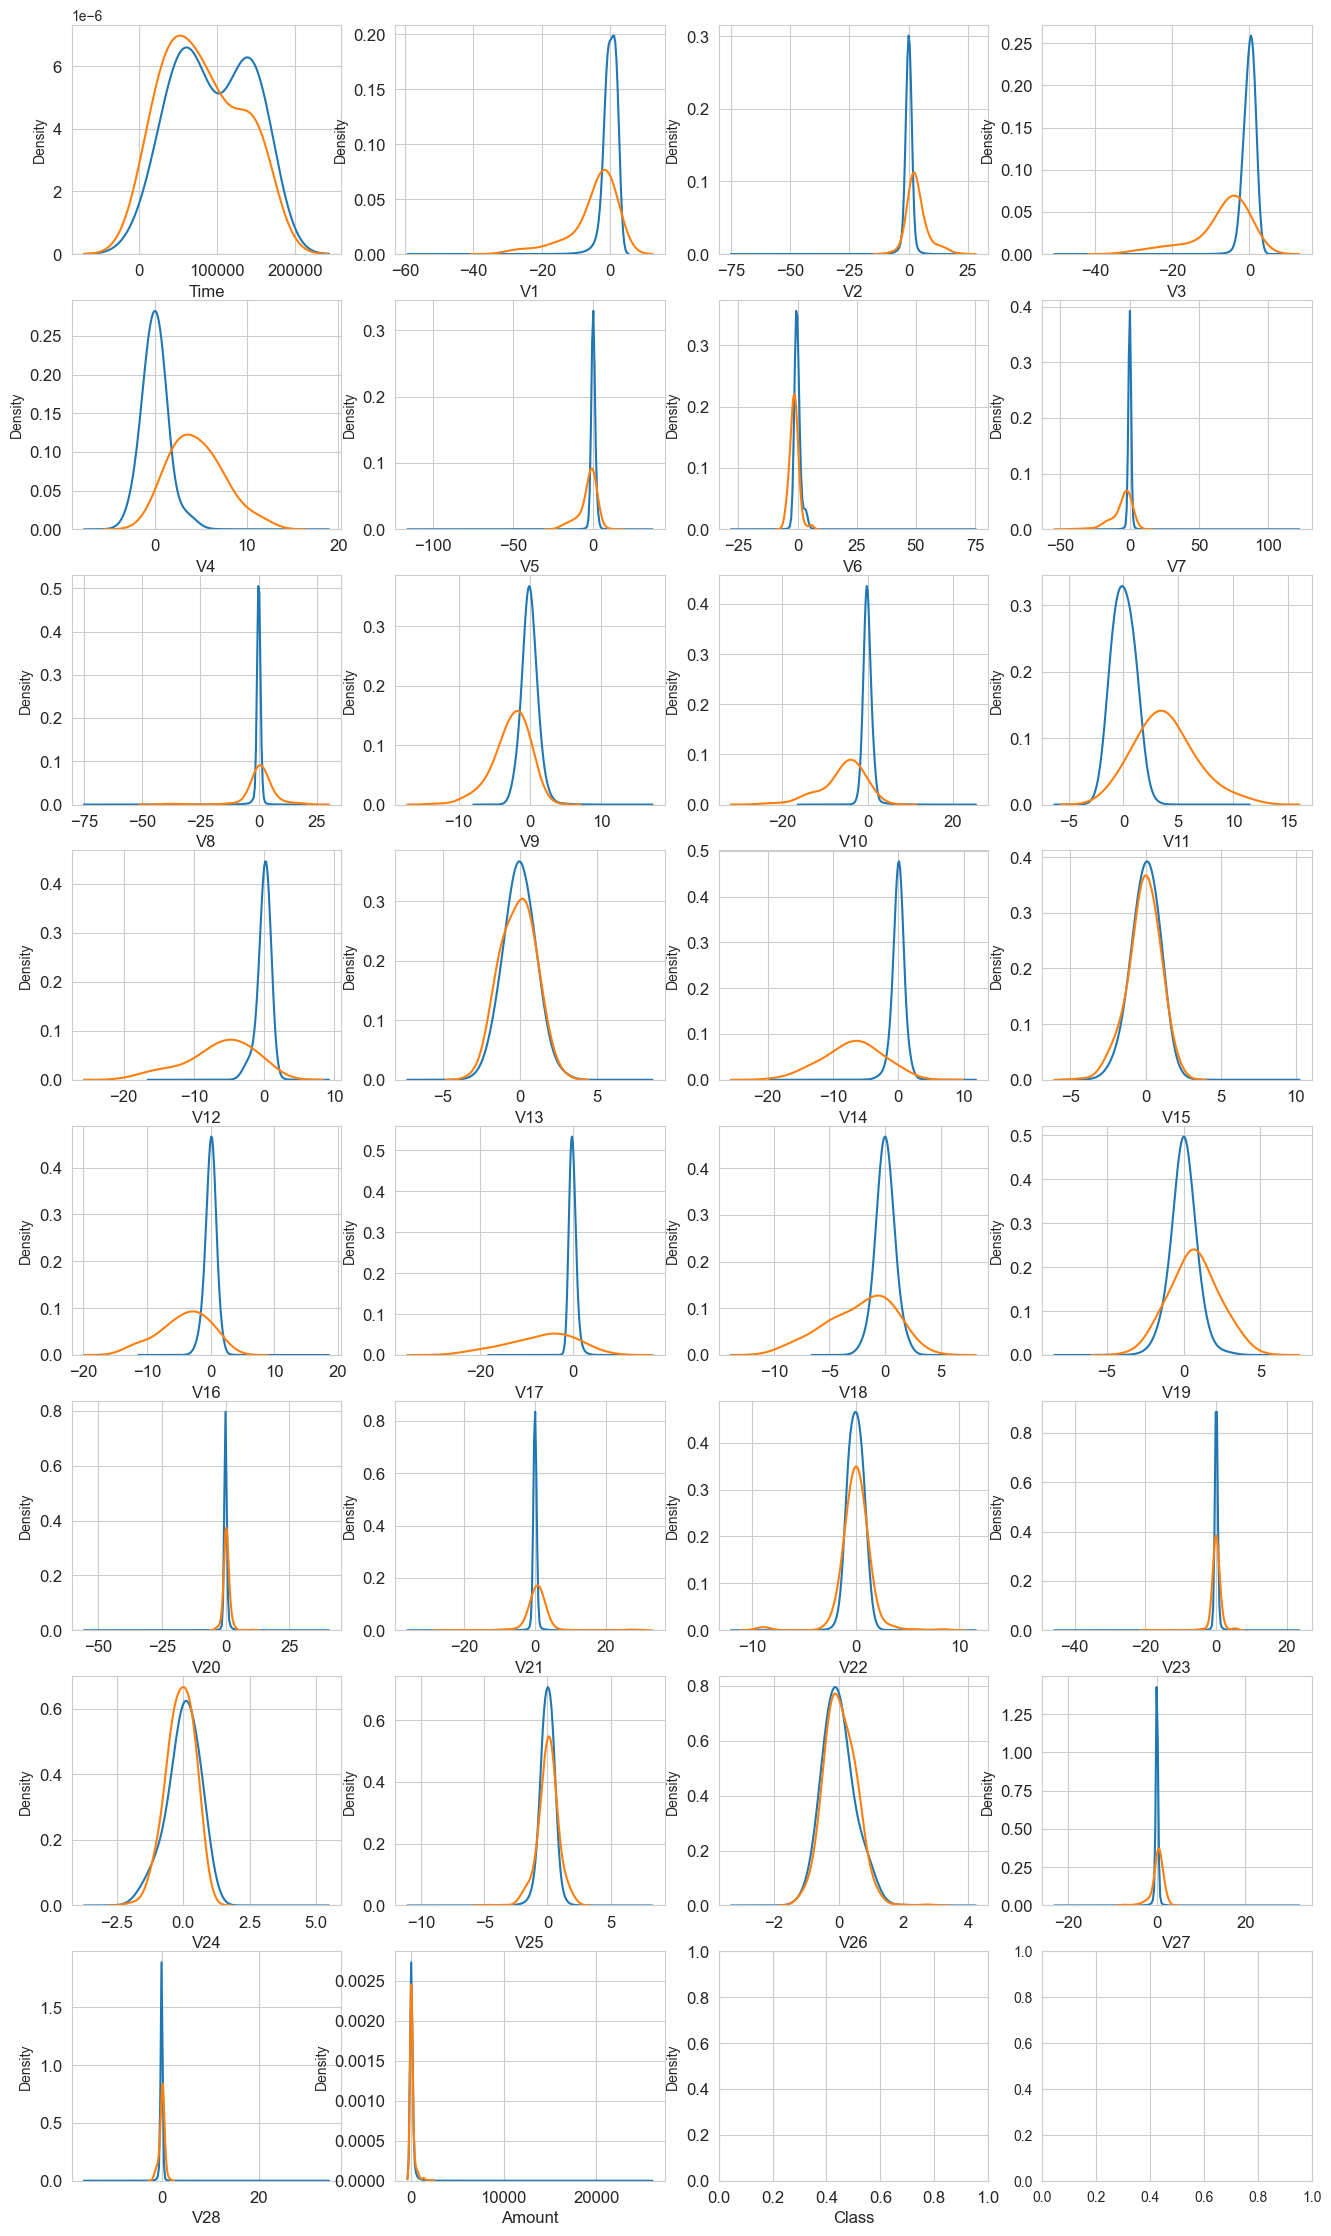

In [16]:
var = df.columns.values

i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

For some of the features we can observe a good selectivity in terms of distribution for the two values of Class: **V4, V11** have clearly separated distributions for **Class** values  **0 and 1, V12, V14, V18** are partially separated, **V1, V2, V3, V10** have a quite distinct profile, whilst **V25, V26, V28** have similar profiles for the two values of Class.

In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions (values of **Class = 0**) is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of **Class = 1**) have a skewed (asymmetric) distribution.

## Predictive models

### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [24]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

### Split data in train, test and validation set

Let's define train, validation and test sets.

In [28]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

Let's start with a RandomForrestClassifier model.

## RandomForestClassifier

### Define model parameters

Let's set the parameters for the model.

Let's run a model using the training set for training. Then, we will use the validation set for validation.

We will use as validation criterion **GINI**, which formula is **GINI = 2 * (AUC) - 1**, where **AUC** is the **Receiver Operating Characteristic - Area Under Curve (ROC-AUC)**. Number of estimators is set to **100** and number of parallel jobs is set to **4**.

We start by initializing the RandomForestClassifier.

In [36]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [39]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Let's now predict the target values for the **valid_df** data, using **predict** function.

In [42]:
preds = clf.predict(valid_df[predictors])

Let's also visualize the features importance.

## Features importance

C:\Users\shubh\AppData\Local\Temp\ipykernel_28736\3805015948.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



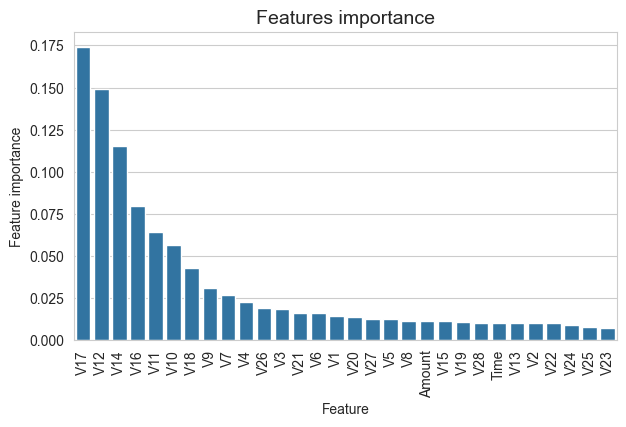

In [46]:

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

The most important features are **V17, V12, V14, V10, V11, V16**

## Confusion matrix

Let's show a confusion matrix for the results we obtained

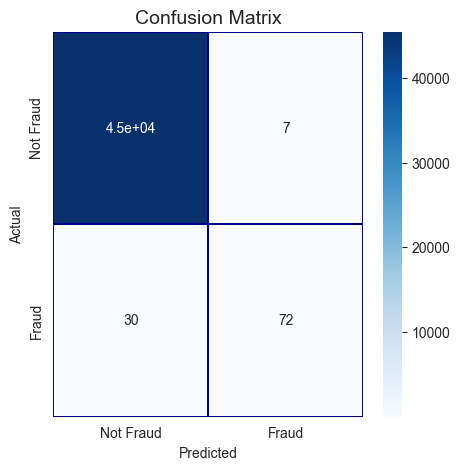

In [52]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

### Type I error and Type II error

We need to clarify that confussion matrix are not a very good tool to represent the results in the case of largely unbalanced data, because we will actually need a different metrics that accounts in the same time for the **selectivity** and **specificity** of the method we are using, so that we minimize in the same time both **Type I errors** and **Type II errors**.

**Null Hypothesis (H0)** - The transaction is not a fraud.

Alternative Hypothes s (H1) - The transaction is a fraud.

Type I error - You reject the null hypothesis when the null hypothesis is actually true.

Type II error - You fail to reject the null hypothesis when the the alternative hypothesis is true.

Cost of Type I error - You erroneously presume that the the transaction is a fraud, and a true transaction is rejected.

Cost of Type II error - You erroneously presume that the transaction is not a fraud and a ffraudulent transaction is accepted. accepted.

Let's calculate the ROC-AUC score

Area under curve

In [61]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

The **ROC-AUC** score obtained with RandomForrestClassifier is **0.85**.

## AdaBoostClassifier

AdaBoostClassifier stands for Adaptive Boosting Classifier

Prepare the model

Let's set the parameters for the model and initialize the model.

In [68]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

#### Fit the model

Let's fit the model.

In [72]:
clf.fit(train_df[predictors], train_df[target].values)

C:\Users\shubh\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [73]:
AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

## Predict the target values

Let's now predict the **target** values for the **valid_df** data, using predict function.

In [76]:
preds = clf.predict(valid_df[predictors])

### Features importance

Let's see also the features importance.

C:\Users\shubh\AppData\Local\Temp\ipykernel_28736\1428594667.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator



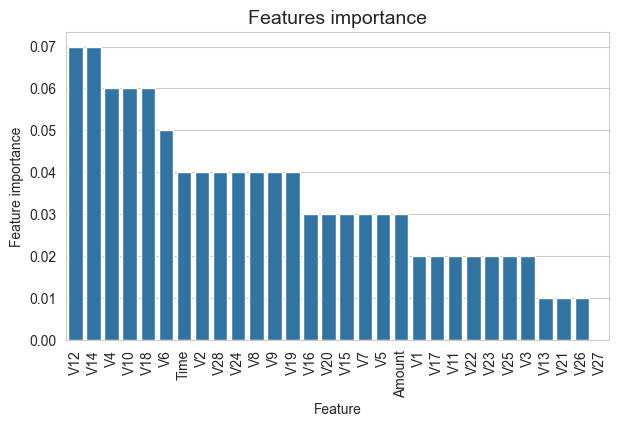

In [79]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

### Confusion Matrix

Let's visualize the confusion matrix.

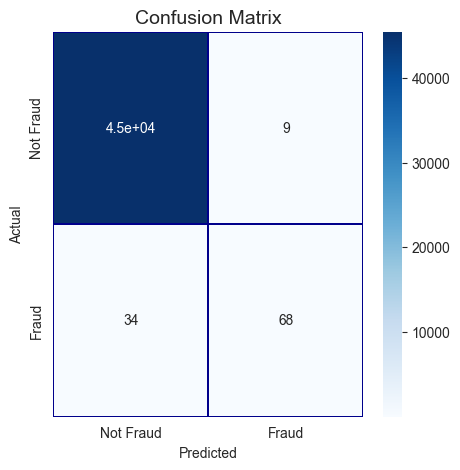

In [86]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Let's calculate also the ROC-AUC.

#### Area under curve

In [90]:
roc_auc_score(valid_df[target].values, preds)

0.8332343604519027

The ROC-AUC score obtained with AdaBoostClassifier is 0.83.

#### CatBoostClassifier

CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data.

#### Prepare the model

Let's set the parameters for the model and initialize the model.

In [98]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [100]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 1.01s	remaining: 8m 25s
50:	total: 42.2s	remaining: 6m 11s
100:	total: 1m 20s	remaining: 5m 19s
150:	total: 1m 58s	remaining: 4m 33s
200:	total: 2m 36s	remaining: 3m 53s
250:	total: 3m 17s	remaining: 3m 15s
300:	total: 3m 56s	remaining: 2m 36s
350:	total: 4m 35s	remaining: 1m 56s
400:	total: 5m 15s	remaining: 1m 17s
450:	total: 5m 56s	remaining: 38.8s
499:	total: 6m 36s	remaining: 0us


### Predict the target values

Let's now predict the target values for the val_df data, using predict function.

In [ ]:
preds = clf.predict(valid_df[predictors])

### Features importance

Let's see also the features importance.

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

### Confusion matrix

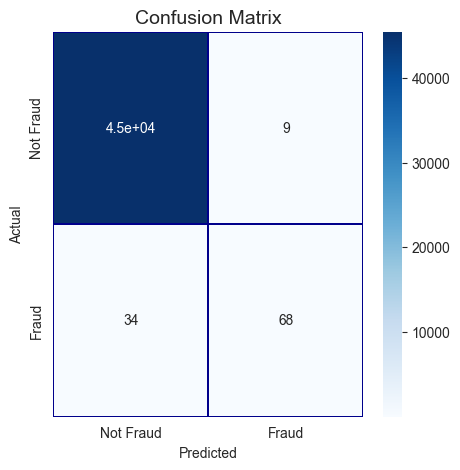

In [106]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Let's calculate also the ROC-AUC.

#### Area under curve

In [110]:
roc_auc_score(valid_df[target].values, preds)

0.8332343604519027

The ROC-AUC score obtained with CatBoostClassifier is 0.86.

### XGBoost

XGBoost is a gradient boosting algorithm.

Let's prepare the model.

#### Prepare the model

We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [117]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

### Train the model

Let's train the model.

In [121]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

C:\Users\shubh\anaconda3\Lib\site-packages\xgboost\core.py:723: FutureWarning:

Pass `evals` as keyword args.

C:\Users\shubh\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[20:26:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.94070	valid-auc:0.88630
[50]	train-auc:0.94200	valid-auc:0.89009
[100]	train-auc:0.97584	valid-auc:0.96685
[150]	train-auc:0.98525	valid-auc:0.97960
[200]	train-auc:0.99279	valid-auc:0.98495
[250]	train-auc:0.99493	valid-auc:0.98352
[258]	train-auc:0.99519	valid-auc:0.98386


The best validation score (ROC-AUC) was 0.984, for round 241.

Plot variable importance

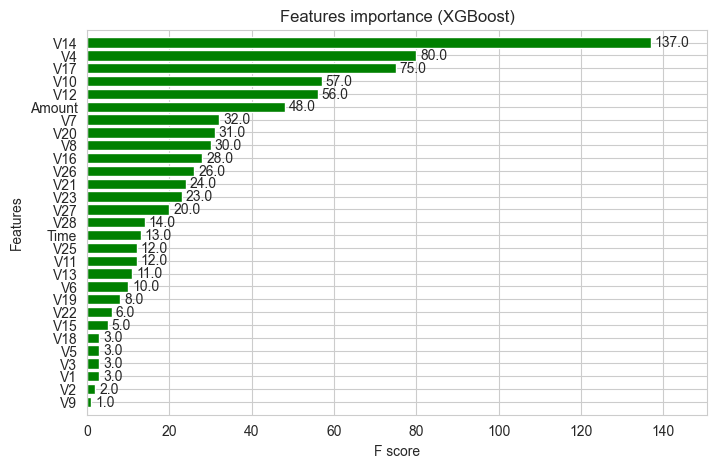

In [125]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

#### Predict test set

We used the train and validation sets for training and validation. We will use the trained model now to predict the target value for the test set.

In [129]:
preds = model.predict(dtest)

### Area under curve

Let's calculate ROC-AUC.

In [133]:
roc_auc_score(test_df[target].values, preds)

0.9803156765502444

The AUC score for the prediction of fresh data (test set) is **0.979**

In [136]:
import joblib
# Save the model
joblib.dump(model, "credit_card_model.pkl")

['credit_card_model.pkl']

### Load the Model

In [139]:
# Load the model
model = joblib.load("credit_card_model.pkl")

### Conclusions

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. We then investigated two predictive models. The data was split in 3 parts, a train set, a validation set and a test set. For the first three models, we only used the train and test set.

We started with **RandomForrestClassifier**, for which we obtained an AUC scode of **0.85** when predicting the target for the test set.

We followed with an **AdaBoostClassifier** model, with lower AUC score **(0.83)** for prediction of the test set target values.

We then followed with an **CatBoostClassifier**, with the AUC score after training 500 iterations **0.86**.

We then experimented with a **XGBoost** model. In this case, se used the validation set for validation of the training model. The best validation score obtained was 0.984. Then we used the model with the best training step, to predict target value from the test data; the AUC score obtained was **0.974**.

In this analysis, we performed a comprehensive exploration and modeling process for credit card fraud detection using an imbalanced dataset. The steps included:

Data Exploration and Preprocessing: We began by loading and exploring the dataset, visualizing class imbalance, and performing necessary preprocessing steps.

Correlation Analysis: By investigating the correlations between features, we gained insights into how features interact with each other. This helped in identifying potential redundancies and understanding feature relationships.

Handling Imbalanced Data: We applied techniques such as undersampling and oversampling to address the class imbalance. This was crucial in ensuring that our models could better learn from the minority class.

Model Training and Evaluation: We trained and evaluated various classifiers, including Logistic Regression, Decision Tree, and RandomForest. We assessed model performance using metrics such as confusion matrices, classification reports, ROC-AUC scores, and ROC curves.

Model Saving: The trained models were saved for future use, ensuring that we can easily load and apply them for predictions on new data.

Key Findings: Feature Correlations: Our correlation analysis revealed important relationships between features. This understanding can guide feature selection and engineering in future analyses.

Model Performance: The RandomForestClassifier demonstrated high accuracy in detecting fraud, showing that it is a strong candidate for deployment. The ROC-AUC scores and ROC curves provided insights into each model’s performance, particularly in distinguishing between fraudulent and non-fraudulent transactions.

Impact of Imbalance Handling: Techniques for balancing the dataset were essential in improving model performance and ensuring that the minority class (fraudulent transactions) was adequately represented in the training process.

Overall, this analysis has provided a robust framework for credit card fraud detection. The insights gained from feature correlations and model evaluations will be instrumental in refining our approach and improving detection capabilities. Future work could involve fine-tuning models further, experimenting with additional features, and exploring other advanced techniques for handling imbalanced data.

